In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
from Multi_User_Channel_Generation_new import Generate_Channel as GC

ModuleNotFoundError: No module named 'Multi_User_Channel_Generation_new'

In [2]:
# Deciding the system parameters
# Tx Bandwidth is 100 MHz

K = 8    # No. of users
noise = -170 + 10 * np.log10(1000 * 1e6)   # noise in dBm
#print(noise)
ite = 1            #no of channel realisations
noise = 10 ** (noise/10 - 3) #linear scale
#print(noise)
N = 50                   #no of elements in IRS
M = 8

In [3]:
Hd = np.zeros((ite,K,M), dtype='complex')
Hr = np.zeros((ite,K,N), dtype='complex')
G = np.zeros((ite,N,M), dtype='complex')

for j in range(ite):
  CG= GC(K, M, N)
  Hd1, Hr1, G1= CG.Generate_Channels()
  Hd[j, :, :]= Hd1.T
  Hr[j, :, :]= Hr1.T
  G[j, :, :]= G1

print(Hr.shape)
#print("Hr=\n",Hr)

print(G.shape)
#print("G=\n",G)

print(Hd.shape)
#print("Hd=\n",Hd)

(1, 8, 50)
(1, 50, 8)
(1, 8, 8)


In [4]:
power_dBm = np.array(range(-2, 13, 2))
P_mW = 10 ** (power_dBm/10) * 0.001
P_range = len(P_mW)

# Initialize the beamforming matrix W randomly
W_1 =  np.random.rand(M,K) + 1j * np.random.rand(M,K)
W = np.zeros((M,K), dtype='complex')
W_ni = np.zeros((M,K), dtype='complex')
for i in range(K):
  W[:,i] = np.sqrt(1/K) * W_1[:,i] / np.linalg.norm(W_1[:,i])
  W_ni[:,i] = W_1[:,i] / np.linalg.norm(W_1[:,i])

wk = np.linalg.norm(W, axis = 0)
wk = np.sort(wk)

# Initialising the phases at IRS
phase0 = np.random.rand(N)*2*np.pi
v = np.exp(1j*phase0)
Theta = np.diag(v)

Ch_eq = np.zeros((ite,K,M), dtype='complex')
P_user = np.zeros((P_range,K))
print(Ch_eq.shape)
print(W.shape)



(1, 8, 8)
(8, 8)


In [5]:

def Alternating_Optimisation( P, K):
    iter_max = 4


    theta_AO = np.zeros((ite,N,K))
    rate_AO = np.zeros((K))
    rate_i = np.zeros((ite,K, iter_max))
    print(P)
    for j in range(ite):
        W = np.sqrt(P/K) * W_1 / np.linalg.norm(W_1,axis=0)
        
        for i in range(K):
            temp = 0
            for iter in range(iter_max):
                theta= np.angle(Hd[j,i,:] @ W[:,i]) - np.angle((np.diag(Hr[j,i,:]) @ G[j,:,:] @ W[:,i])) 
                v = np.exp(1j*theta)
                Theta = np.diag(v)  

                Ch_eq[j,i,:] = Hd[j,i,:] + Hr[j,i,:] @ Theta @ G[j,:,:]
                W[:,i] = np.sqrt(P/K) * np.conj(Ch_eq[j,i,:]).T / np.linalg.norm(Ch_eq[j,i,:])  #MRT equation
            for k in range(K):
                if k != i:
                    temp += (np.linalg.norm(Ch_eq[j,i,:] @ W[:,k]))**2

            rate_i[j,i,iter] = np.log2(1+(np.linalg.norm(Ch_eq[j,i,:] @ W[:,i]) **2)/ (temp + noise))
                #print(rate_i[j,iter])
            theta_AO[j,:,i] = theta  # optimised Phase Shifts value for user 'x'
    for i in range(K):
        rate_AO[i] = np.mean(rate_i[:,i,iter_max-1], axis=0)
    
    #print('rate_AO=',rate_AO)
    #print(np.sum(rate_AO))
    #print('optimised theta for user X =\n ',theta_AO)
    #print('Ch_eq=', Ch_eq)
    return  theta_AO
    
     

In [6]:
for p in range(P_range):
    P = 10 ** (power_dBm[p]/10) * 0.001
    
    theta0_zf = Alternating_Optimisation(P, K)
    print(theta0_zf)



0.0006309573444801933
[[[ 3.10334916e+00 -2.64452130e-01 -2.80572207e+00  1.05217228e+00
    1.00026421e+00  1.24289711e+00  7.18682407e-01  2.42042650e+00]
  [ 1.44066580e+00  1.22460677e+00  2.75929006e+00  2.14825640e+00
    2.52266439e+00  5.82693766e-01  1.03067244e+00  2.76462329e+00]
  [-2.86251928e+00  2.83211818e+00 -2.97749819e+00  1.46973512e+00
    1.63955114e+00  5.33956972e-01  8.86385198e-01 -1.81992591e+00]
  [-1.48893210e+00  2.44830514e+00 -2.77325421e+00 -3.07032109e+00
    2.01273921e+00  6.98673293e-01  1.60208018e+00 -2.01680971e+00]
  [ 2.27097187e+00  2.54560193e+00 -3.04670358e+00  2.77486296e+00
    1.27813410e+00  1.27137132e+00  9.32919619e-01  3.07004664e+00]
  [ 2.17547582e+00  3.75818319e-01 -2.28081739e+00  1.60630681e+00
    1.70784079e+00  1.79924466e+00  5.42450417e-01  2.38146162e+00]
  [ 1.05162127e+00  4.92828476e-01 -1.62841176e+00  1.31715128e+00
    1.36614014e+00  5.57178879e-01  1.26125975e+00 -2.96624606e+00]
  [ 3.12408620e+00  1.92364288e+0

In [7]:
def water_fill_8users_2(K, power_dBm, wk):
    s_lst = np.zeros((ite,K))     #store the norm of each column of precoder
    g_lst = np.zeros((ite,K))     #store the inverse of SNR for each channel
    P_k = np.zeros(K)       #store the allocated power for each user
    nu = np.zeros(K)        #store the threshold
    nu_opt = 0
    sum = 0
    P = 10 ** ((power_dBm/10) - 3)
    #wk = [wk]
    print(wk)
    for j in range(ite):
        for i in range(K):
            s_lst[j,i] = wk[i]**2
            g_lst[j,i] = noise * s_lst[j,i]
            #print('g=',g_lst)
            sum = sum + g_lst[j,i]
            #print('sum=',sum)
            nu[i] = (P + sum)/(i+1)
            #print('nu value=',nu[i])
    #print('g_lst=',g_lst)


    threshold_achieved = False  #threshold is not achieved
    for j in range(ite):
        for i in range(K-1):
            if ((nu[i] - g_lst[j,i+1])<0):
                nu_opt = nu[i]
                threshold_achieved = True #threshold is achieved
                P_k[i] = nu_opt - g_lst[j,i]
                break

    if threshold_achieved==False:  #if threshold is not achieved 
        nu_opt = nu[K-1]
    #print('nu_opt=',nu_opt)
    for j in range(ite):
        for i in range(K):
            temp = nu_opt - g_lst[j,i]
            P_k[i]= temp if temp>=0 else 0
                

    #print('P_k=',P_k)
    #print('sum of all P_k=',np.sum(P_k))
    #print('nu =',nu)
       
    return P_k


In [8]:
def ZeroForcing(K,M, Hd, Hr, G, power_dBm,x):
    W2 = np.zeros((ite, M,K), dtype= 'complex')
    pk = []
    rate_k = np.zeros((ite,K))
    rate_zf = np.zeros(K)
      # user preffered
    for j in range(ite):
        
        v = np.exp(1j * theta0_zf[j,:,x])
       # print(v.shape)
        Theta = np.diag(v)
        #print(Theta.shape)
        Ch_eq[j,:,:] = Hd[j,:,:] + Hr[j,:,:] @ Theta @ G[j,:,:]
        #print('Ch_eq=', Ch_eq.shape)
        W2[j,:,:] = np.linalg.pinv(Ch_eq[j,:,:])
        #print('W2=',W2)
        
        for i in range(K):
            temp = 0
            #print(W2.shape)
            wk = np.linalg.norm(W2[j,:,:],axis=0)
            wk = np.sort(wk)
            #print(wk.shape)
            #print('wk=',wk)

            pk.append( water_fill_8users_2(K,power_dBm,wk))
            print('power allocated',pk)



            print(pk)
            W[:,i] = pk[0][i] *  ( W2[j,:,i]/wk[i])

            for k in range(K):
                if k!=i:
                    temp += (np.linalg.norm(Ch_eq[j,i,:] @ W[:,k]))**2
            
            rate_k[j,i] = np.log2(1+(np.linalg.norm(Ch_eq[j,i,:] @ W[:,i]))**2)/(temp + noise)
            
    for i in range(K):
        rate_zf[i] = np.mean(rate_k[:,i], axis=0)
    #print(rate_zf)
    #print(np.sum(rate_zf))

    return (rate_zf)
            
            
        

In [9]:
wsr_zf_x1 = np.zeros((P_range,K))
wsr_zf_x2 = np.zeros((P_range,K))
wsr_zf_x3 = np.zeros((P_range,K))
wsr_zf_x4 = np.zeros((P_range,K))
wsr_zf_x5 = np.zeros((P_range,K))
wsr_zf_x6 = np.zeros((P_range,K))
wsr_zf_x7 = np.zeros((P_range,K))
wsr_zf_x8 = np.zeros((P_range,K))
SR1 = np.zeros((P_range))
SR2 = np.zeros((P_range))
SR3 = np.zeros((P_range))
SR4 = np.zeros((P_range))
SR5 = np.zeros((P_range))
SR6 = np.zeros((P_range))
SR7 = np.zeros((P_range))
SR8 = np.zeros((P_range))

for p in range(P_range):
    x1=0
    wsr_zf_x1[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x1)
    x2 = 1
    wsr_zf_x2[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x2)
    x3=2
    wsr_zf_x3[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x3)
    x4 = 3
    wsr_zf_x4[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x4)
    x5=4
    wsr_zf_x5[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x5)
    x6 = 5
    wsr_zf_x6[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x6)
    x7=6
    wsr_zf_x7[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x7)
    x8 = 7
    wsr_zf_x8[p,:]= ZeroForcing(K,M, Hd, Hr, G, power_dBm[p],x8)
print('rate1=\n',wsr_zf_x1)


[  1119.60230892   5535.66587264   7859.52348395  14422.18032974
  36020.829317    79281.20172634  94417.45743367 137889.59668753]
power allocated [array([0.00046243, 0.00016853, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])]
[array([0.00046243, 0.00016853, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])]
[  1119.60230892   5535.66587264   7859.52348395  14422.18032974
  36020.829317    79281.20172634  94417.45743367 137889.59668753]
power allocated [array([0.00046243, 0.00016853, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ]), array([0.00046243, 0.00016853, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])]
[array([0.00046243, 0.00016853, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ]), array([0.00046243, 0.00016853, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])]
[  1119.60230892   5535.665872

In [10]:
SR1 = np.sum(wsr_zf_x1,axis=1)
print('sum rate1=', SR1)

print('\n')

SR2 = np.sum(wsr_zf_x2,axis=1)
#print('rate2=\n',wsr_zf_x2)
print('sum rate2 =', SR2)
print('\n')

SR3 = np.sum(wsr_zf_x3,axis=1)
print('sum rate3=', SR3)

print('\n')

SR4 = np.sum(wsr_zf_x4,axis=1)
#print('rate2=\n',wsr_zf_x2)
print('sum rate4 =', SR4)
print('\n')

SR5 = np.sum(wsr_zf_x5,axis=1)
print('sum rate5=', SR5)

print('\n')

SR6 = np.sum(wsr_zf_x6,axis=1)
#print('rate2=\n',wsr_zf_x2)
print('sum rate6 =', SR6)
print('\n')

SR7 = np.sum(wsr_zf_x7,axis=1)
print('sum rate7=', SR7)

print('\n')

SR8 = np.sum(wsr_zf_x8,axis=1)
#print('rate2=\n',wsr_zf_x2)
print('sum rate8 =', SR8)



sum rate1= [2.19268025e-05 4.66739242e-02 8.03739710e-02 1.52803444e-01
 3.15345305e-01 6.45170098e-01 1.26753180e+00 2.68219697e+00]


sum rate2 = [0.02777371 0.05657251 0.11064635 0.20473099 0.41327405 0.81229285
 1.59008479 3.35478827]


sum rate3= [0.02155906 0.03933808 0.07150048 0.14236027 0.30464586 0.68742329
 1.35053256 2.84086261]


sum rate4 = [0.02139889 0.04305405 0.07886836 0.14751779 0.3004814  0.65394747
 1.27656539 2.63039721]


sum rate5= [0.02408977 0.04587307 0.09482142 0.17500319 0.33209923 0.68405969
 1.40428607 2.75113468]


sum rate6 = [0.0400108  0.07422339 0.14133518 0.24800928 0.47855989 0.99882838
 1.93144194 3.88226459]


sum rate7= [0.03072086 0.05865474 0.12140986 0.23455489 0.43960622 0.89631873
 1.82037912 3.5521514 ]


sum rate8 = [0.02027769 0.0424454  0.07733072 0.14863899 0.30957914 0.62758328
 1.24360217 2.64920153]


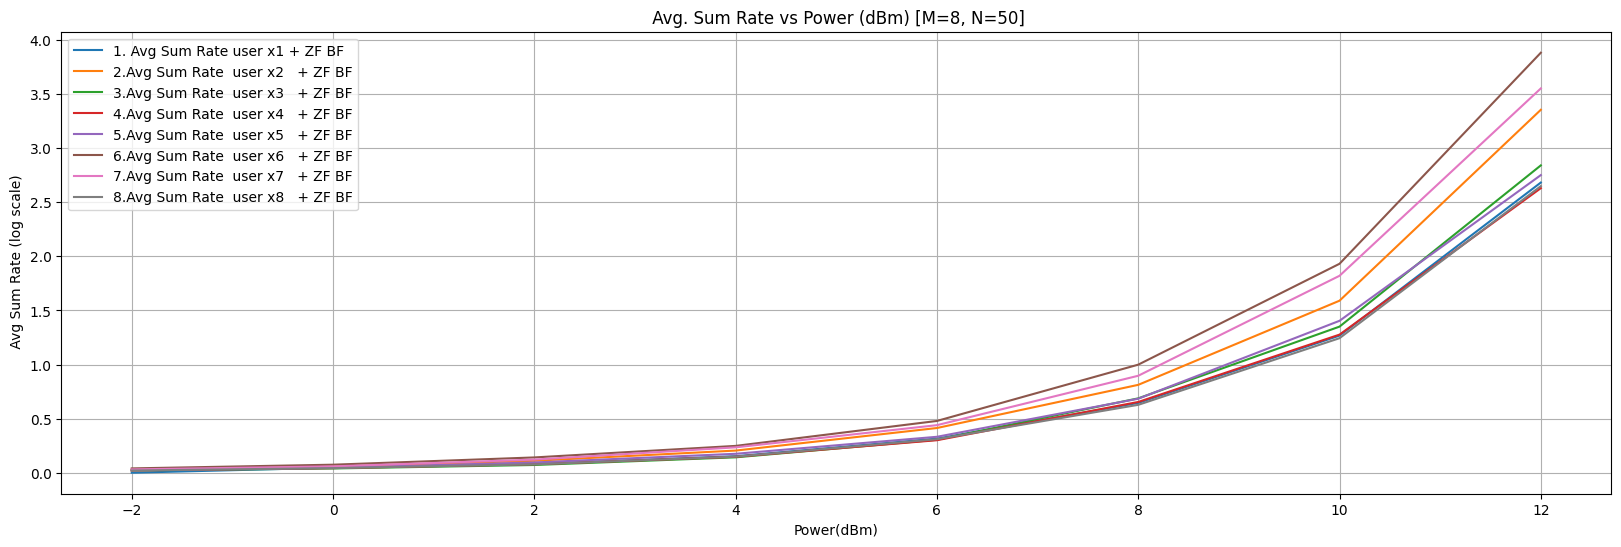

In [11]:
plt.figure(figsize=(20,6))
plt.plot(power_dBm,SR1,  label='1. Avg Sum Rate user x1 + ZF BF ')

plt.plot(power_dBm,SR2, label='2.Avg Sum Rate  user x2   + ZF BF')
plt.plot(power_dBm,SR3, label='3.Avg Sum Rate  user x3   + ZF BF')
plt.plot(power_dBm,SR4, label='4.Avg Sum Rate  user x4   + ZF BF')
plt.plot(power_dBm,SR5, label='5.Avg Sum Rate  user x5   + ZF BF')
plt.plot(power_dBm,SR6, label='6.Avg Sum Rate  user x6   + ZF BF')
plt.plot(power_dBm,SR7, label='7.Avg Sum Rate  user x7   + ZF BF')
plt.plot(power_dBm,SR8, label='8.Avg Sum Rate  user x8   + ZF BF')




plt.title(' Avg. Sum Rate vs Power (dBm) [M=8, N=50]')
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate (log scale)')
plt.grid(True)
plt.legend()
plt.show()
 # 